# End to End Project

The project uses the *California Housing Prices* dataset from **StatLib** repository, which is based on 1990 California census.

In [1]:
# libraries
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

It's a good practice (and also to reduce future work) to always create fuctions that **fetch and load** the dataset, so let's create it.

In [2]:
# fetching the data
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
MAIN = os.getcwd()

# function to get the data
def fetching_data(housing_url = HOUSING_URL):
    tgz_path = os.path.join(MAIN, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall()
    housing_tgz.close()

# getting the data
fetching_data()

In [3]:
# function to import the data
def load_dataset():
    csv_path = os.path.join(os.getcwd(), 'housing.csv')
    return pd.read_csv(csv_path)

# importing data and checking it's structure
housing = load_dataset()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Brief EDA

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The dataset has 9 columns, with one categorical variable (*ocean_proximity*) and 8 quantitative variables.

There are 20.640 observations, but 207 missing data in *total_bedrooms* column.

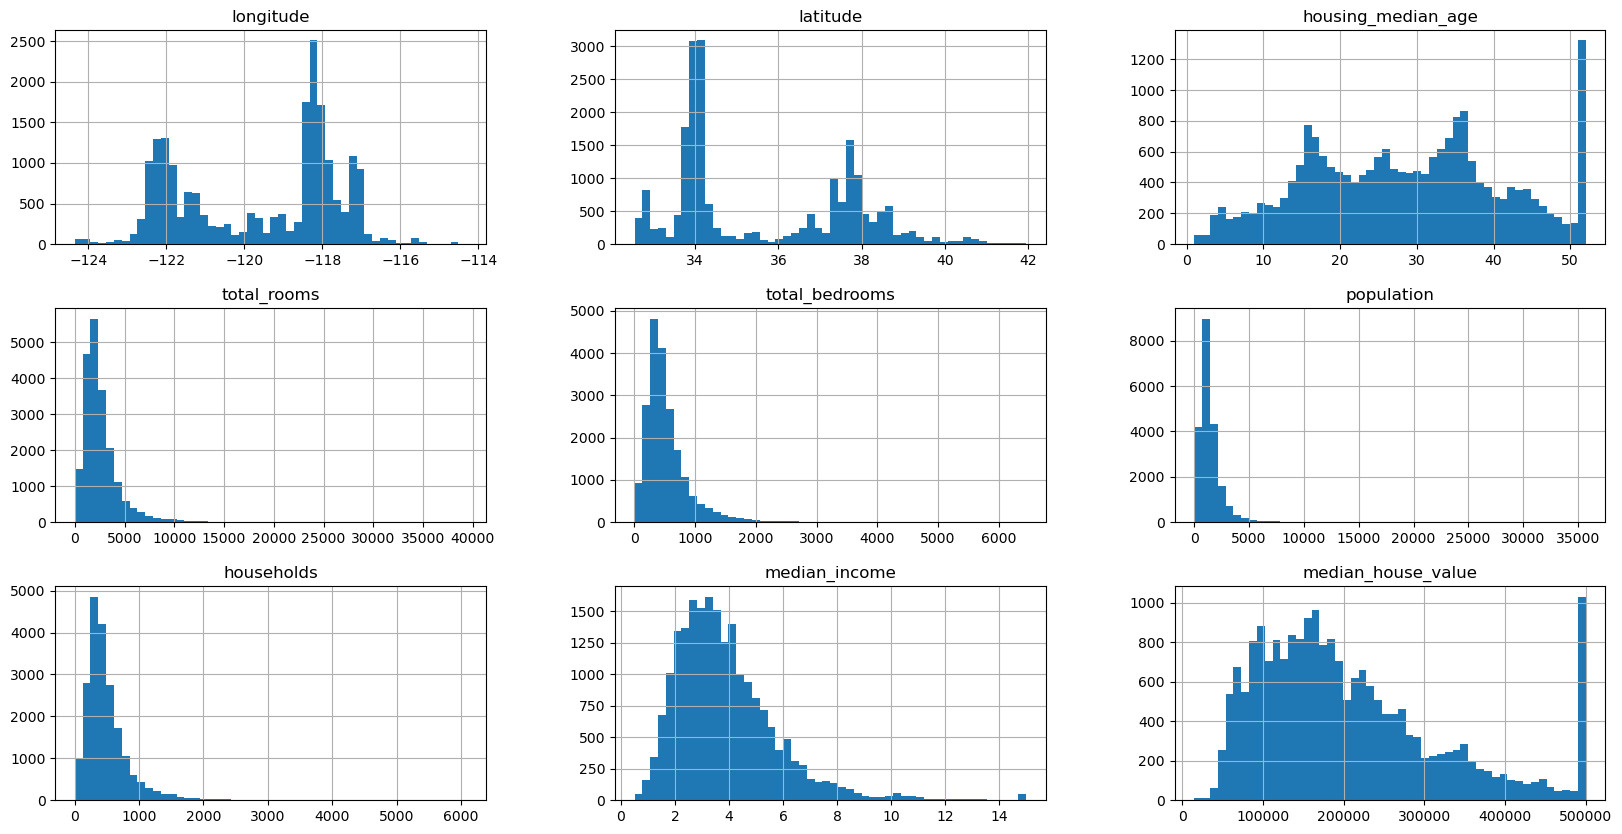

In [5]:
# checking data distribution with histogram
housing.hist(bins=50, figsize=(20,10))
plt.show()

With the histogram, we can easily note that:

1. the discrete variables *total_rooms*, *total_bedrooms*, *population*, *households*; and continous variables *median_income* and *median_house_value* are strongly **right skewed**, with the latter ones apparently having outliers;

2. the first 3 plotted variables seem to be multimodal;

3. *median_income* is expressed in terms of tens of thousands of dollars;

4. maybe it might be helpful to standardize some of these variables

## Train and Test sets

It's important to know how well a model performs, and how sensible it is to knew data. To check it out, we can use train and validation sets.

### Simple Random Sampling

In [6]:
from sklearn.model_selection import train_test_split

# train-test split with scikit-learn
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42) # test set has 20% of the data

### Stratified Random Sampling

One approach to the problem would be to divide the median income into intervals, considering each interval as a separate group within the same population, as follows

<Axes: >

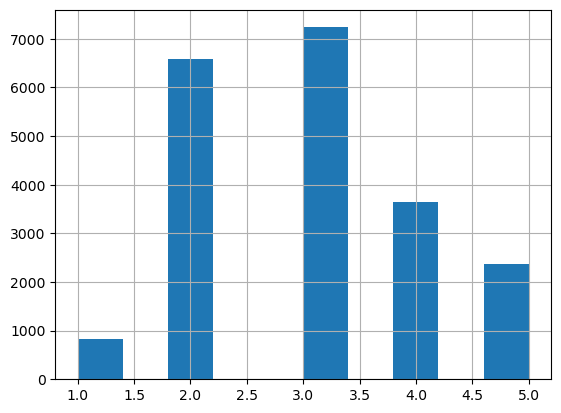

In [7]:
# creating the stratum (groups)
housing['income_cat'] = pd.cut(housing['median_income'],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1,2,3,4,5])

housing['income_cat'].hist()

 We could say this new variable has a normal, or approximatly, a normal distribution?

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

# creting stratified 'sampler'
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# new sets
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


# checking
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

Just to be sure, and to compare the skewness, let's see the proportions of *income_cat* for each data set

In [9]:
# new full random sample
new_train, new_test = train_test_split(housing, test_size=0.2, random_state=42)

# proportions
original_data = housing['income_cat'].value_counts()/len(housing)
stratfied_data = strat_test_set['income_cat'].value_counts()/len(strat_test_set)
random_data = new_test['income_cat'].value_counts()/len(new_test)

# comparison
pd.DataFrame({ 'Original':original_data,
             'Stratified':stratfied_data,
             'Random':random_data,
             'Str. % Error':((stratfied_data / original_data)-1)*100,
             'Ran. %Error':((random_data / original_data)-1)*100 }).sort_values(by='income_cat')

,Original,Stratified,Random,Str. % Error,Ran. %Error
income_cat,,,,,
1,0.039826,0.039971,0.040213,0.364964,0.973236
2,0.318847,0.318798,0.324370,-0.015195,1.732260
3,0.350581,0.350533,0.358527,-0.013820,2.266446
4,0.176308,0.176357,0.167393,0.027480,-5.056334
5,0.114438,0.114341,0.109496,-0.084674,-4.318374


Notice how big are the errors from the random approach.

Now, we can delete the *income_cat* column, since we already got a representative sample.

In [10]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

## Getting more details on the data

Let's see if we can find any more details about the relationships within the data, but first, we need a copy of the dataframe (so changes won't affect the original one)

In [11]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

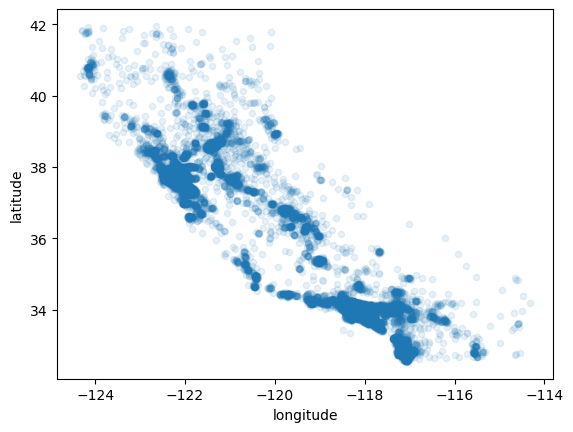

In [12]:
# cheching relation on latitude and longitude
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

<Axes: xlabel='longitude', ylabel='latitude'>

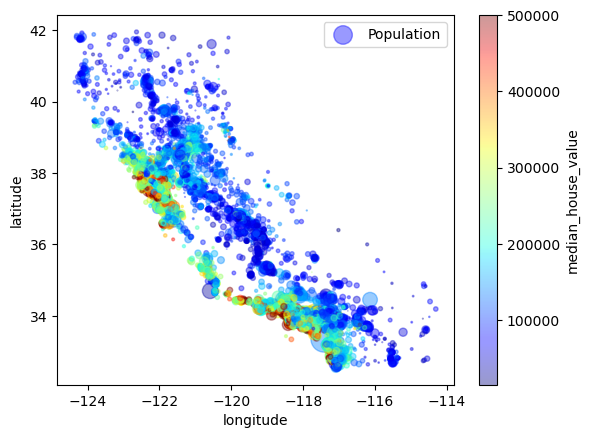

In [13]:
# detailed plot
housing.plot(kind='scatter',
              x='longitude',
              y='latitude',
              alpha=0.4,
              s=housing['population']/100,
              label='Population',
              c='median_house_value',
              cmap=plt.get_cmap('jet'),
             colorbar=True)

In [14]:
# now let's look for Pearson's correlations
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

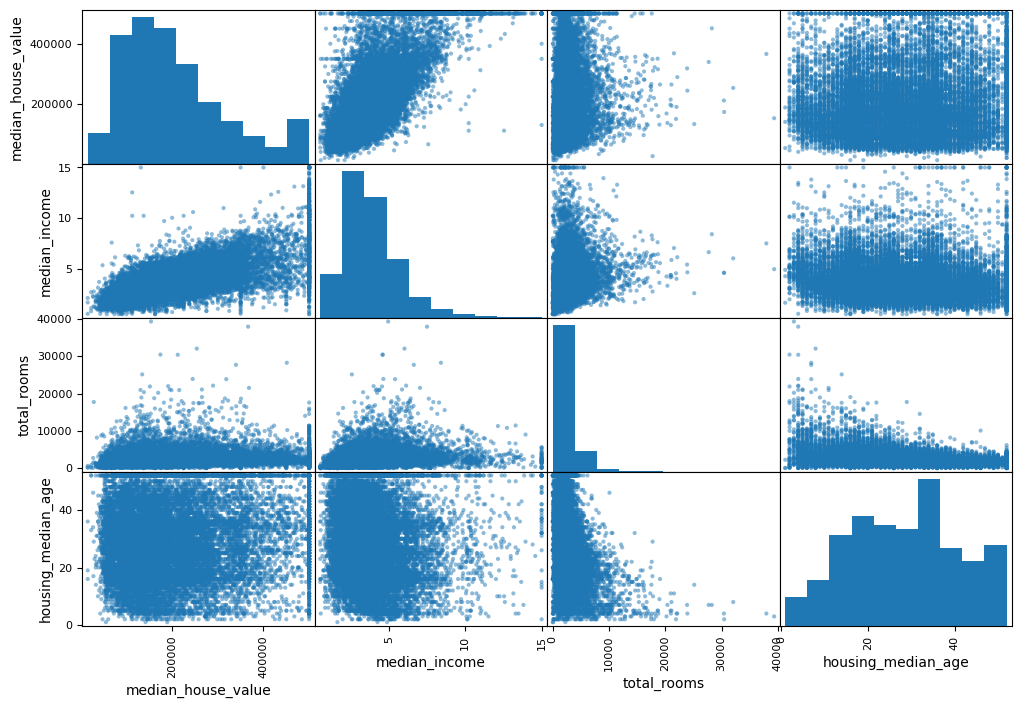

In [15]:
# let's see it in plots
from pandas.plotting import scatter_matrix

attr = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attr], figsize=(12,8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

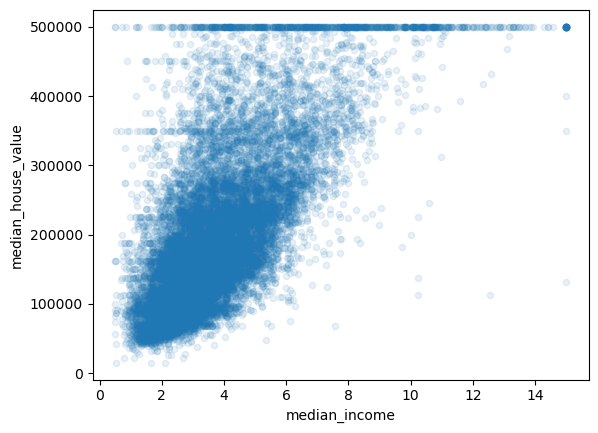

In [16]:
# median_income is the most related variable
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

Notice that there're some price caps, which we can delete from the data (not the better option) or simply make a transformation, as follows.

### Attribute Combinations

The following new variables are more correlated with the response variable, as attested by Pearson's correlation.

In [17]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

## Data Cleaning

In [18]:
# creates copy of the dataframe
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### Missing values

In [19]:
# we will use median inputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1) # copy new set 'cause the method don't accept categorical values
imputer.fit(housing_num)
print(f'Imputer Statistics: {list(imputer.statistics_)}\n\nValues Imputed: {list(housing_num.median().values)}')

Imputer Statistics: [-118.51, 34.26, 29.0, 2119.0, 433.0, 1164.0, 408.0, 3.54155]

Values Imputed: [-118.51, 34.26, 29.0, 2119.0, 433.0, 1164.0, 408.0, 3.54155]


In [20]:
# now that we have the inputer fitted, we apply it to the training set
X = imputer.transform(housing_num)

# we use the following in case we want a dataframe structure:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


### Handling categorical data

In out dataset, the only categorical data we have is **ocean_proximity**. We must transform it to a quantitative variable, doing it in two ways:

1. simply apply different numbers to each category
2. create new attributes with non-zero values based on the given category

The first approach may cause some trouble to the algorithm, since it can interpret that nearby numbers may have higher correlation/influence over each other. So, to this problem the second approach looks more reasonable

In [21]:
# first approach
housing_cat = housing[['ocean_proximity']]

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
# housing_cat_encoded[:10]
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [22]:
# second approach
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
# housing_cat_1hot is a sparse matrix (scipy) which is faster than numpy arrays, specially for several categories
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom transformer class

It's interesting to have a class or classes with custom transformers, so this way we can apply several operations with only one function

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6 # column numbers

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]

        if self.add_bedrooms_per_room:
            bedrooms__per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms__per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling

We saw that some data transformations are needed in order to improve it's quality, and also to make our model get the most out of it.

Along with that, we could also add the previous transformation, using a structure called Pipeline.

In [24]:
# transforming numerical variables

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # standardizes the data

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())])


housing_num_tr = num_pipeline.fit_transform(housing_num)

In [25]:
# transforming in all the dataset

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)])


housing_prepared = full_pipeline.fit_transform(housing)

## Train and Evaluate a model

In [26]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(housing_prepared, housing_labels) # fit training set

LinearRegression()

In [27]:
# testing 
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lm.predict(some_data_prepared).round(1))
print("Labels:", list(some_labels))

Predictions: [ 85657.9 305492.6 152056.5 186095.7 244550.7]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [28]:
# getting metrics
from sklearn.metrics import mean_squared_error

housing_predictions = lm.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(f'The prediction error is about ${lin_rmse:,.0f}')

# the model is probably underfitting

The prediction error is about $68,628


In [29]:
# new approach
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(f'The prediction error is about ${tree_rmse:,.1f}')

# the model is overfitting

The prediction error is about $0.0


### Cross-Validation

In [30]:
# k-fold cross-validation for decision tree
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10) # 10 folds
tree_rmse_scores = np.sqrt(-scores)

def show_scores(scores):
    print('Scores:', scores)
    print(f'\nMean: {scores.mean():,.0f}')
    print(f'\nStd: {scores.std():,.0f}')


show_scores(tree_rmse_scores)

Scores: [71326.69419566 70365.31671244 67736.07330436 73235.92393252
 70439.44234559 75863.94471356 70924.93019042 72838.1859331
 67207.98538306 72304.72846646]

Mean: 71,224

Std: 2,431


In [31]:
# k-fold cross-validation for linear regression

lin_scores = cross_val_score(lm, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10) # ten folds
lin_rmse_scores = np.sqrt(-lin_scores)
show_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]

Mean: 69,104

Std: 2,880


With that, we can see that Decision Tree method is overfitting so badly that it performs worse than Linear Regression.

Let's try another approach: Random Forests.

In [32]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(housing_prepared, housing_labels)

rf_pred = rf.predict(housing_prepared)
rf_mse = mean_squared_error(housing_labels, rf_pred)
rf_rmse = np.sqrt(rf_mse)

print(f'The prediction error is about ${rf_rmse:,.1f}')

# much better than the two previous models!!!

The prediction error is about $18,738.8


In [33]:
# k-fold cross-validation for random forest

rf_scores = cross_val_score(rf, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10) # 10 folds
rf_rmse_scores = np.sqrt(-rf_scores)
show_scores(rf_rmse_scores)

Scores: [51573.4450236  48981.15811839 46795.84315264 51845.53063291
 47023.21593646 52022.11899883 52805.67579245 50454.49325906
 48639.28700522 53828.35416915]

Mean: 50,397

Std: 2,305


## Fine Tunning - Grid Search

With a few possible good models selected, we could now test different combinations of hyperparameters, aiming to get the most out of the model(s).

We can achieve that automatically with *GridSearchCV*, that despite may take a while to run, returns good results. Let's apply it to the RandomForest model, with a pre-defined number of parameters.

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]}
]

# param_grid tries:
# 1. 3 x 4 combinations of n_estimators and max_features, with bootstrap active
# 2. 2 x 3 combinations of ... , with bootstrap unactive
# a total of 18 combinations is done 5 times (cross-validation=5), resulting in 90 rounds of training

rf = RandomForestRegressor()
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [35]:
# let's see the results
print(f'Best parameters: {grid_search.best_params_}')
print('')

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(f'RMSE: {np.sqrt(-mean_score):,.1f} \t Parameters: {params}')

Best parameters: {'max_features': 6, 'n_estimators': 30}

RMSE: 63,963.8 	 Parameters: {'max_features': 2, 'n_estimators': 3}
RMSE: 55,488.6 	 Parameters: {'max_features': 2, 'n_estimators': 10}
RMSE: 52,721.9 	 Parameters: {'max_features': 2, 'n_estimators': 30}
RMSE: 61,011.3 	 Parameters: {'max_features': 4, 'n_estimators': 3}
RMSE: 52,927.7 	 Parameters: {'max_features': 4, 'n_estimators': 10}
RMSE: 50,391.3 	 Parameters: {'max_features': 4, 'n_estimators': 30}
RMSE: 58,999.8 	 Parameters: {'max_features': 6, 'n_estimators': 3}
RMSE: 52,339.6 	 Parameters: {'max_features': 6, 'n_estimators': 10}
RMSE: 49,858.9 	 Parameters: {'max_features': 6, 'n_estimators': 30}
RMSE: 58,772.3 	 Parameters: {'max_features': 8, 'n_estimators': 3}
RMSE: 52,642.6 	 Parameters: {'max_features': 8, 'n_estimators': 10}
RMSE: 50,220.3 	 Parameters: {'max_features': 8, 'n_estimators': 30}
RMSE: 63,128.0 	 Parameters: {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
RMSE: 53,757.5 	 Parameters: {

## Evaluation on Test Set

First, let's find out the importance of each feature to the model.

In [36]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.51731744e-02, 6.52601437e-02, 4.23110867e-02, 1.69818016e-02,
       1.64430949e-02, 1.71796573e-02, 1.56495024e-02, 3.55584266e-01,
       5.13688022e-02, 1.05328112e-01, 7.00108977e-02, 1.17395631e-02,
       1.49298905e-01, 1.44460379e-04, 4.47946909e-03, 3.04706359e-03])

In [37]:
extra_attr = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_onehot_attr = list(cat_encoder.categories_[0])
attr = num_attribs + extra_attr + cat_onehot_attr
sorted(zip(feature_importances, attr),reverse=True)

[(0.3555842662114806, 'median_income'),
 (0.14929890513979757, 'INLAND'),
 (0.10532811155488904, 'pop_per_hhold'),
 (0.07517317438163026, 'longitude'),
 (0.07001089770363786, 'bedrooms_per_room'),
 (0.06526014370584789, 'latitude'),
 (0.051368802245379826, 'rooms_per_hhold'),
 (0.0423110866610955, 'housing_median_age'),
 (0.017179657288599652, 'population'),
 (0.016981801644689366, 'total_rooms'),
 (0.016443094896591754, 'total_bedrooms'),
 (0.01564950239883963, 'households'),
 (0.011739563108658509, '<1H OCEAN'),
 (0.004479469089898742, 'NEAR BAY'),
 (0.003047063589851997, 'NEAR OCEAN'),
 (0.00014446037911181435, 'ISLAND')]

In [38]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prep = full_pipeline.transform(X_test) # we don't want to fit the test set!!!
final_predictions = final_model.predict(X_test_prep)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) # 48,480 approximately

In [39]:
# let's compute a confidence interval from the t distribution
from scipy import stats

conf = 0.95
squared_errors = (final_predictions - y_test) ** 2 
np.sqrt(stats.t.interval(conf, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([45660.94727497, 49537.51521173])

With that, we evaluated our model, and other possible steps to take would be to train/test another models (optional, or when needed), and finally do some more automation work, to improve the speed of the whole process for it to be deployed.